In [1]:
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torchio as tio
import matplotlib.pyplot as plt
from torchvision import ops

from glio import nn as gnn
from glio.nn import conv, convt, linear
from glio.torch_tools import summary, lr_finder
from glio.python_tools import type_str
from glio.train import *
from glio.data.DS import DSToTarget
from glio.datasets import LUMIERE
from glio.python_tools import CacheRepeatIterator
from glio.jupyter_tools import clean_mem, show_slices, show_slices_arr
from glio.visualize import vis_imshow_grid, vis_imshow, Visualizer
from glio.loaders import nifti
from glio.train import *
from glio.points import Point, BoundingBox, draw_point, draw_bbox, bbox_from_xxdd as xxdd

## Загрузчик
Загрузчик возращает `[T1, Mask, BBox]`.

Чёрную область вокруг изображения можно удалить `[25:-25,25:-35,20:-20]`.

Получаем `132, 158, 142`

Трансформация берёт каждый 9 саггитальный срез, получаем 16 срезов из 142. Можно потом попробовать воспользоваться изменением размера.


### mean / std
- T1 image - `3567939758e+01`; `161.2564239502`
- FLAIR image - `5.9002014160e+01`; `129.0489959717`
- T1 mask - `2.4059068412e-02`; `0.2359057516`


In [2]:
lum = LUMIERE.LUMIERE()
print(lum.col_names())

slices = [slice(25,-25),slice(25,-35),slice(20,-20)]
ch_slices = [slice(None), *slices]
d = lum.get_cols(["T1 image", "T1 mask", "T1 contrast-enhancing bbox"])

mean_std = (7.3567939758e+01, 0), (161.2564239502, 1)
def normalize(x:torch.Tensor):
    return (x - x.mean()) / x.std()


def loader(x: dict):
    img3d = torch.stack(((nifti.read(x["T1 image"])), nifti.read(x["T1 mask"])))[:,*slices].permute(0,3,2,1)
    shape = img3d.shape
    img3d = img3d[:, ::9]
    img3d[0] = normalize(img3d[0])
    mask = F.one_hot(img3d[1].to(torch.int64)).permute(3, 0, 1, 2)
    return img3d[0], mask, xxdd(x["T1 contrast-enhancing bbox"], arr=shape).crop(slices).permute(2,1,0).translate(img3d).center()
    #bbox = x["T1 contrast-enhancing bbox"]

sample_idx = 1
sample_img, sample_mask, sample_bbox = loader(d[sample_idx])
print(f"{sample_img.shape = }, {sample_mask.shape = }")
print(f"{sample_img.min() = }, {sample_img.max() = }, {sample_img.mean() = }, {sample_img.std() = }")#type:ignore
print(f"{sample_mask.min() = }, {sample_mask.max() = }, {sample_mask.dtype = }")#type:ignore

def transform_init(x: tuple[torch.Tensor,torch.Tensor, Point]): return x
def transform_sample(x: tuple[torch.Tensor,torch.Tensor, Point]):
    return x[0]
def transform_target(x: tuple[torch.Tensor,torch.Tensor, Point]):
    return x[1], x[2].to_rel().coords

ds = DSToTarget(n_threads=8)
ds.add_samples(d, loader, transform_init, transform_sample, transform_target)
print(len(ds))
ds_train, ds_test = ds.split(0.85)
# mean_std = ds_train.get_mean_std(16, 8)
print(len(ds_train), len(ds_test))

print('preloading DS_train...')
ds_train.preload(1/2)
print('preloading DS_test...')
#ds_test.preload(1/2)

def loss_gen(loss_fn):
    def lossf(x, y:tuple):
        return loss_fn(x, (torch.stack(y[1]).T).to(torch.float32))
    return lossf

['Patient', 'Survival time (weeks)', 'Sex', 'Age at surgery (years)', 'IDH (WT: wild type)', 'IDH method', 'MGMT qualitative', 'MGMT quantitative', 'Date', 'LessThan3Months', 'NonMeasurableLesions', 'RANO', 'bbox', 'CT1 image', 'CT1 mask', 'CT1 necrosis bbox', 'CT1 hga-image', 'CT1 hga-mask', 'CT1 hga-non-enhancing bbox', 'CT1 hga-contrast-enhancing bbox', 'T1 hga-image', 'T1 hga-mask', 'T1 hga-non-enhancing bbox', 'T1 hga-contrast-enhancing bbox', 'T2 hga-image', 'T2 hga-mask', 'T2 hga-non-enhancing bbox', 'T2 hga-contrast-enhancing bbox', 'FLAIR hga-image', 'FLAIR hga-mask', 'FLAIR hga-non-enhancing bbox', 'FLAIR hga-contrast-enhancing bbox', 'CT1 contrast-enhancing bbox', 'CT1 edema bbox', 'T1 image', 'T1 mask', 'T1 necrosis bbox', 'T1 contrast-enhancing bbox', 'T1 edema bbox', 'T2 image', 'T2 mask', 'T2 necrosis bbox', 'T2 contrast-enhancing bbox', 'T2 edema bbox', 'FLAIR image', 'FLAIR mask', 'FLAIR necrosis bbox', 'FLAIR contrast-enhancing bbox', 'FLAIR edema bbox']
sample_img.sh

## Модель

In [3]:
class CNN_Base_center(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv(16, 24, 4, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.conv2 = conv(24, 32, 3, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.conv3 = conv(32, 48, 2, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.conv4 = conv(48, 64, 2, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.conv5 = conv(64, 64, 2, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.linear = linear(64*4*4, 3, flatten=True, act=None)
    def forward(self, x:torch.Tensor):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return self.linear(x)

summary(CNN_Base_center(), (8, 16, 158, 132))

path                                         module                                       input size               output size              params    buffers   
__main__.CNN_Base_center/conv1/0             torch.nn.modules.conv.Conv2d                 (8, 16, 158, 132)        (8, 24, 78, 65)          6168      0         
__main__.CNN_Base_center/conv1/1             torch.nn.modules.activation.GELU             (8, 24, 78, 65)          (8, 24, 78, 65)          0         0         
__main__.CNN_Base_center/conv2/0             torch.nn.modules.conv.Conv2d                 (8, 24, 78, 65)          (8, 32, 38, 32)          6944      0         
__main__.CNN_Base_center/conv2/1             torch.nn.modules.activation.GELU             (8, 32, 38, 32)          (8, 32, 38, 32)          0         0         
__main__.CNN_Base_center/conv3/0             torch.nn.modules.conv.Conv2d                 (8, 32, 38, 32)          (8, 48, 19, 16)          6192      0         
__main__.CNN_Base_center/conv3/1  

Iteration 3 done.4114308 loss: 117.71112060546875558


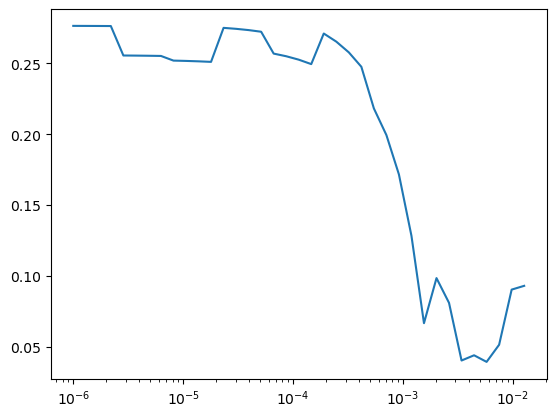

In [4]:
MODEL = CNN_Base_center()
BATCH_SIZE = 16
CACHE_ELEMS = 4

LOSS_FN = nn.MSELoss()
OPT = optim.AdamW(MODEL.parameters())

dl_train = CacheRepeatIterator(DataLoader(ds_train, BATCH_SIZE, shuffle=True), CACHE_ELEMS)
lrs, losses = lr_finder(MODEL, OPT, loss_gen(LOSS_FN), dl_train, mul=1.3, end = 1, niter=4)

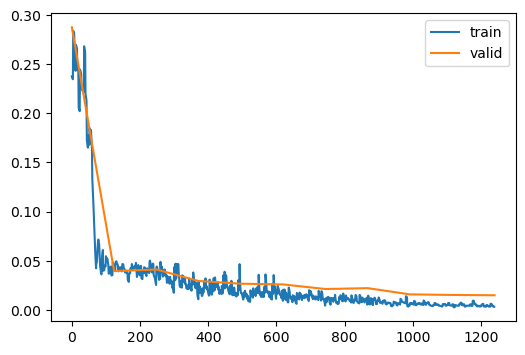

Training took 1222.3462574000005 seconds. Results:
 - last train MSE loss: learner.logger.last("train loss") = 0.0030749954748898745
 - best train MSE loss: learner.logger.min("train loss") = 0.002513719256967306

 - last test MSE loss: learner.logger.last("test loss") = 0.014741680507237712
 - best test MSE loss: learner.logger.min("test loss") = 0.014741680507237712

 - last train L1 loss: learner.logger.last("train fn - lossf") = 0.040641047060489655
 - best train L1 loss: learner.logger.min("train fn - lossf") = 0.03794436156749725

 - last test L1 loss: learner.logger.last("test fn - lossf") = 0.0943020594616731
 - best test L1 loss: learner.logger.min("test fn - lossf") = 0.0943020594616731


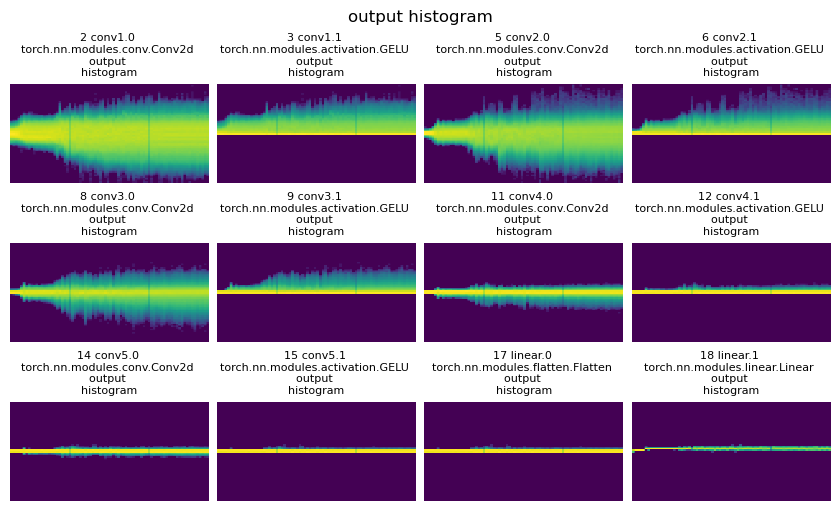

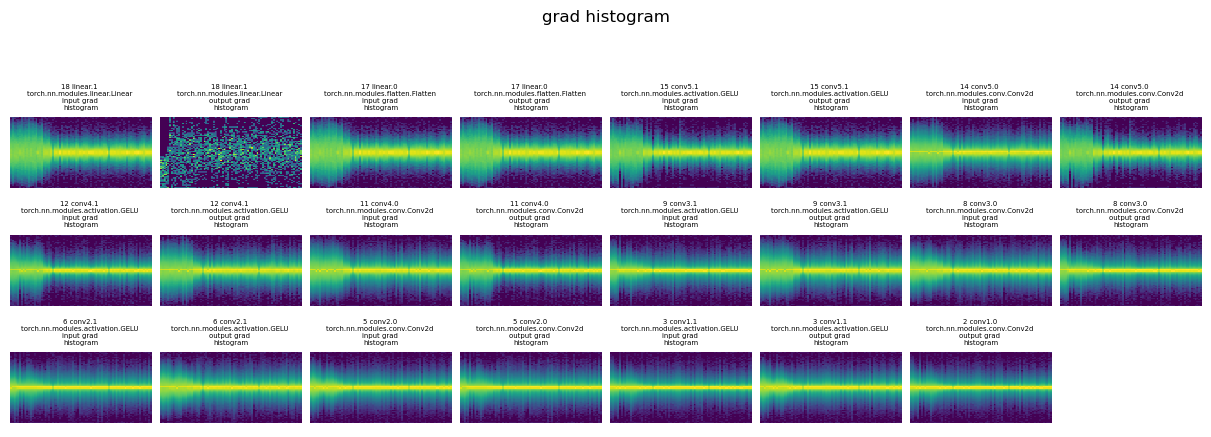

In [5]:
MODEL = CNN_Base_center()
NAME = MODEL.__class__.__name__
LR = 1e-3
BATCH_SIZE = 16
CACHE_ELEMS = 4
N_EPOCHS = 10

dl_train = CacheRepeatIterator(DataLoader(ds_train, BATCH_SIZE, shuffle=True), CACHE_ELEMS)
dl_test = DataLoader(ds_test, BATCH_SIZE)

LOSS_FN = nn.MSELoss()
OPT = optim.AdamW(MODEL.parameters(), lr=LR)
SCHED = optim.lr_scheduler.OneCycleLR(OPT, max_lr=LR, steps_per_epoch=len(dl_train), epochs=N_EPOCHS)

clean_mem()
# dl_train = DataLoader(ds_train, BATCH_SIZE)
#model = gnn.LSUV(model, dl_train)

CP_FOLDER = "LUMIERE checkpoints"
LEARNER_NAME = f"LUMIERE {NAME} lr={LR} bs={BATCH_SIZE} cache={CACHE_ELEMS} loss = {LOSS_FN.__name__ if hasattr(LOSS_FN, '__name__') else type_str(LOSS_FN)} opt={OPT.__class__.__name__} sch={SCHED.__class__.__name__}"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = (Metric_Loss(), Accelerate("no"), FastProgressBar(plot=True, step_batch=16), Metric_Fn(loss_gen(F.l1_loss)), Log_GradHistorgram(16),
                         Log_SignalHistorgram(16), Log_Time(), Save_Best(CP_FOLDER), Save_Last(CP_FOLDER)),
                  loss_fn=loss_gen(LOSS_FN),
                  optimizer=OPT,
                  scheduler=SCHED)
learner.fit(N_EPOCHS, dl_train, dl_test)

print(f"Training took {learner.logger.last('time')} seconds. Results:")
print(f' - last train MSE loss: {learner.logger.last("train loss") = }')
print(f' - best train MSE loss: {learner.logger.min("train loss") = }')
print()
print(f' - last test MSE loss: {learner.logger.last("test loss") = }')
print(f' - best test MSE loss: {learner.logger.min("test loss") = }')
print()
print(f' - last train L1 loss: {learner.logger.last("train fn - lossf") = }')
print(f' - best train L1 loss: {learner.logger.min("train fn - lossf") = }')
print()
print(f' - last test L1 loss: {learner.logger.last("test fn - lossf") = }')
print(f' - best test L1 loss: {learner.logger.min("test fn - lossf") = }')

plt.show()
learner.logger.hist_all("output histogram")
plt.show()
learner.logger.hist_all("grad histogram")

# Addding batch norm

In [6]:
class CNN_BatchNorm_center(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv(16, 24, 4, 2, bias=False, batch_norm=True, dropout=0.0, act=nn.GELU())
        self.conv2 = conv(24, 32, 3, 2, bias=False, batch_norm=True, dropout=0.0, act=nn.GELU())
        self.conv3 = conv(32, 48, 2, 2, bias=False, batch_norm=True, dropout=0.0, act=nn.GELU())
        self.conv4 = conv(48, 64, 2, 2, bias=False, batch_norm=True, dropout=0.0, act=nn.GELU())
        self.conv5 = conv(64, 64, 2, 2, bias=False, batch_norm=True, dropout=0.0, act=nn.GELU())
        self.linear = linear(64*4*4, 3, flatten=True, act=None)
    def forward(self, x:torch.Tensor):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return self.linear(x)

summary(CNN_BatchNorm_center(), (8, 16, 158, 132))

path                                         module                                       input size               output size              params    buffers   
__main__.CNN_BatchNorm_center/conv1/0        torch.nn.modules.conv.Conv2d                 (8, 16, 158, 132)        (8, 24, 78, 65)          6144      0         
__main__.CNN_BatchNorm_center/conv1/1        torch.nn.modules.activation.GELU             (8, 24, 78, 65)          (8, 24, 78, 65)          0         0         
__main__.CNN_BatchNorm_center/conv1/2        torch.nn.modules.batchnorm.BatchNorm2d       (8, 24, 78, 65)          (8, 24, 78, 65)          48        49        
__main__.CNN_BatchNorm_center/conv2/0        torch.nn.modules.conv.Conv2d                 (8, 24, 78, 65)          (8, 32, 38, 32)          6912      0         
__main__.CNN_BatchNorm_center/conv2/1        torch.nn.modules.activation.GELU             (8, 32, 38, 32)          (8, 32, 38, 32)          0         0         
__main__.CNN_BatchNorm_center/conv

Iteration 3 done.9098933 loss: 0.3578651845455169765


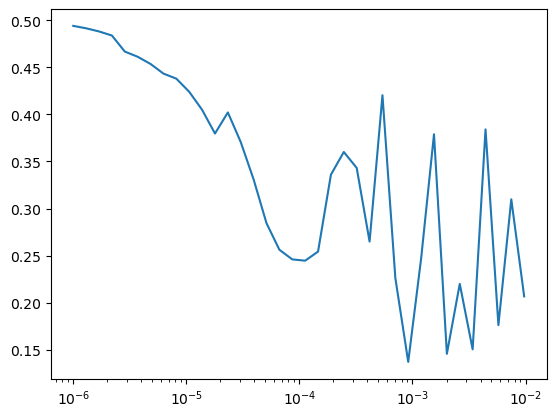

In [7]:
MODEL = CNN_BatchNorm_center()
BATCH_SIZE = 16
CACHE_ELEMS = 4

LOSS_FN = nn.MSELoss()
OPT = optim.AdamW(MODEL.parameters())

dl_train = CacheRepeatIterator(DataLoader(ds_train, BATCH_SIZE, shuffle=True), CACHE_ELEMS)
lrs, losses = lr_finder(MODEL, OPT, loss_gen(LOSS_FN), dl_train, mul=1.3, end = 1, niter=4)

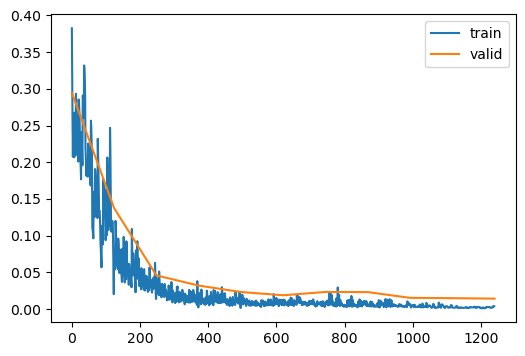

Training took 1055.8136037999066 seconds. Results:
 - last train MSE loss: learner.logger.last("train loss") = 0.0038023176603019238
 - best train MSE loss: learner.logger.min("train loss") = 0.0009703029645606875

 - last test MSE loss: learner.logger.last("test loss") = 0.014107913011685014
 - best test MSE loss: learner.logger.min("test loss") = 0.014107913011685014

 - last train L1 loss: learner.logger.last("train fn - lossf") = 0.04838188737630844
 - best train L1 loss: learner.logger.min("train fn - lossf") = 0.023644104599952698

 - last test L1 loss: learner.logger.last("test fn - lossf") = 0.09205043315887451
 - best test L1 loss: learner.logger.min("test fn - lossf") = 0.09205043315887451


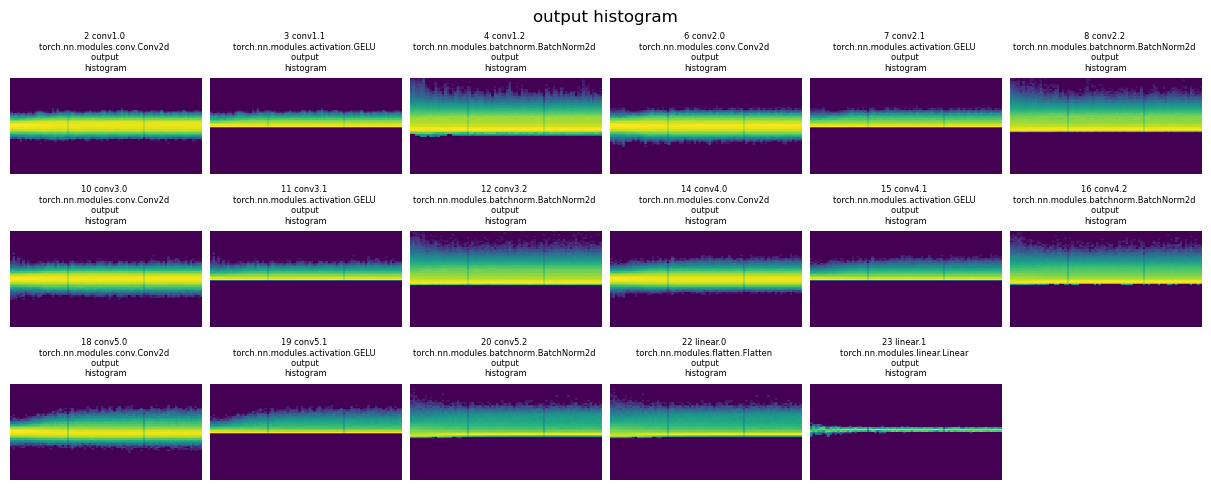

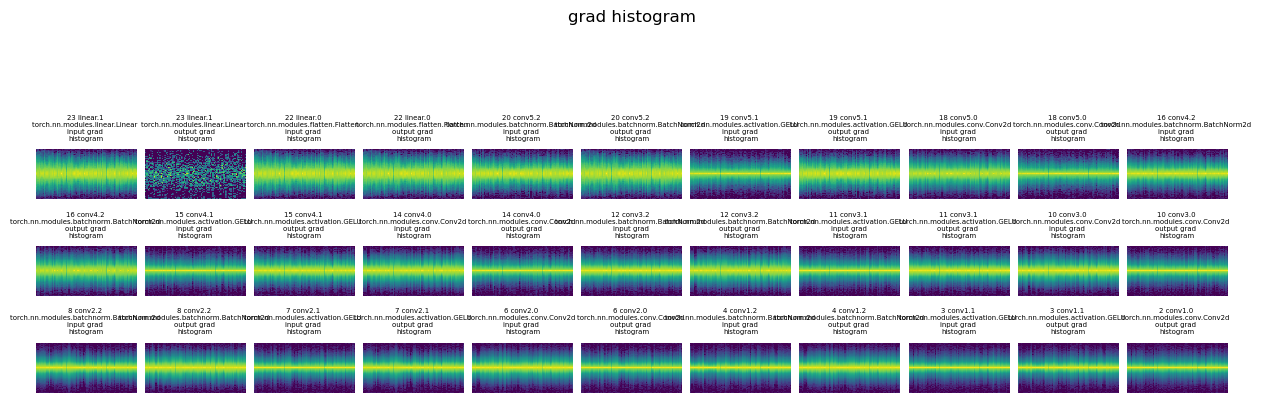

In [8]:
MODEL = CNN_BatchNorm_center()
NAME = MODEL.__class__.__name__
LR = 1e-3
BATCH_SIZE = 16
CACHE_ELEMS = 4
N_EPOCHS = 10

dl_train = CacheRepeatIterator(DataLoader(ds_train, BATCH_SIZE, shuffle=True), CACHE_ELEMS)
dl_test = DataLoader(ds_test, BATCH_SIZE)

LOSS_FN = nn.MSELoss()
OPT = optim.AdamW(MODEL.parameters(), lr=LR)
SCHED = optim.lr_scheduler.OneCycleLR(OPT, max_lr=LR, steps_per_epoch=len(dl_train), epochs=N_EPOCHS)

clean_mem()
# dl_train = DataLoader(ds_train, BATCH_SIZE)
#model = gnn.LSUV(model, dl_train)

CP_FOLDER = "LUMIERE checkpoints"
LEARNER_NAME = f"LUMIERE {NAME} lr={LR} bs={BATCH_SIZE} cache={CACHE_ELEMS} loss = {LOSS_FN.__name__ if hasattr(LOSS_FN, '__name__') else type_str(LOSS_FN)} opt={OPT.__class__.__name__} sch={SCHED.__class__.__name__}"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = (Metric_Loss(), Accelerate("no"), FastProgressBar(plot=True, step_batch=16), Metric_Fn(loss_gen(F.l1_loss)), Log_GradHistorgram(16),
                         Log_SignalHistorgram(16), Log_Time(), Save_Best(CP_FOLDER), Save_Last(CP_FOLDER)),
                  loss_fn=loss_gen(LOSS_FN),
                  optimizer=OPT,
                  scheduler=SCHED)
learner.fit(N_EPOCHS, dl_train, dl_test)

print(f"Training took {learner.logger.last('time')} seconds. Results:")
print(f' - last train MSE loss: {learner.logger.last("train loss") = }')
print(f' - best train MSE loss: {learner.logger.min("train loss") = }')
print()
print(f' - last test MSE loss: {learner.logger.last("test loss") = }')
print(f' - best test MSE loss: {learner.logger.min("test loss") = }')
print()
print(f' - last train L1 loss: {learner.logger.last("train fn - lossf") = }')
print(f' - best train L1 loss: {learner.logger.min("train fn - lossf") = }')
print()
print(f' - last test L1 loss: {learner.logger.last("test fn - lossf") = }')
print(f' - best test L1 loss: {learner.logger.min("test fn - lossf") = }')

plt.show()
learner.logger.hist_all("output histogram")
plt.show()
learner.logger.hist_all("grad histogram")

# Batch Norm means we can get away with 1e-02

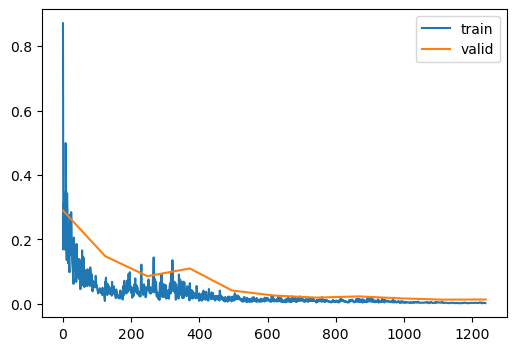

Training took 904.6058899000054 seconds. Results:
 - last train MSE loss: learner.logger.last("train loss") = 0.0019184318371117115
 - best train MSE loss: learner.logger.min("train loss") = 0.0013027368113398552

 - last test MSE loss: learner.logger.last("test loss") = 0.013087700431545576
 - best test MSE loss: learner.logger.min("test loss") = 0.012561287575711807

 - last train L1 loss: learner.logger.last("train fn - lossf") = 0.03559211269021034
 - best train L1 loss: learner.logger.min("train fn - lossf") = 0.02777654305100441

 - last test L1 loss: learner.logger.last("test fn - lossf") = 0.08780272801717122
 - best test L1 loss: learner.logger.min("test fn - lossf") = 0.086124154428641


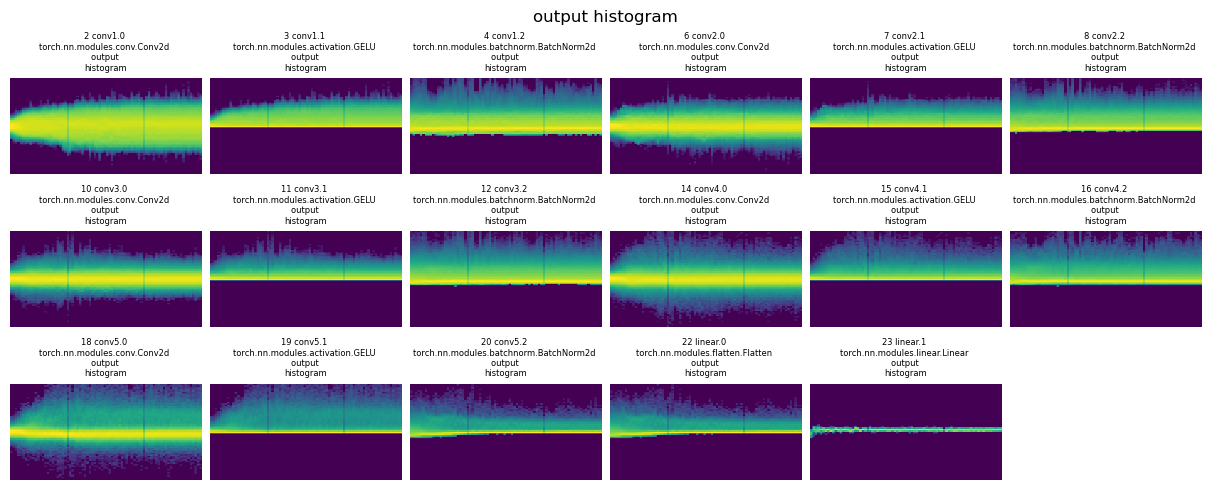

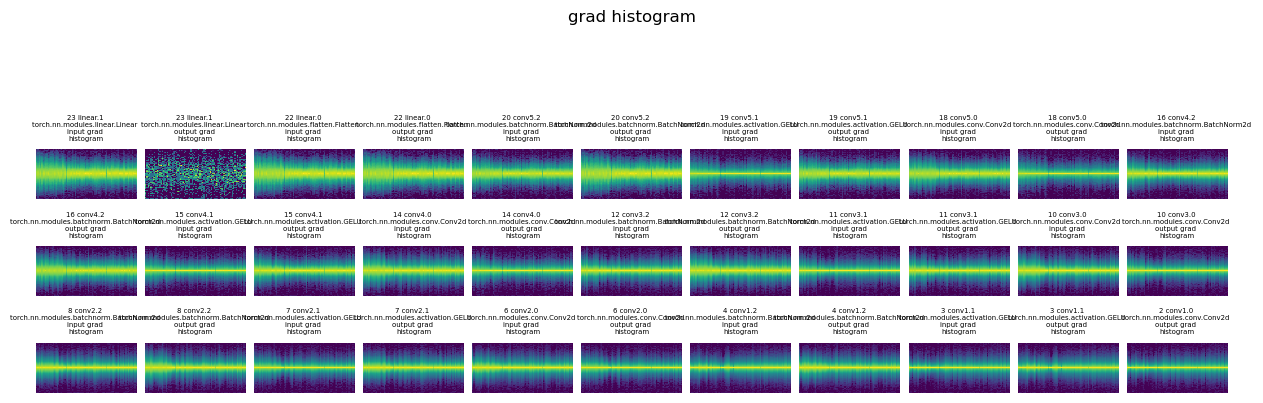

In [9]:
MODEL = CNN_BatchNorm_center()
NAME = MODEL.__class__.__name__
LR = 1e-2
BATCH_SIZE = 16
CACHE_ELEMS = 4
N_EPOCHS = 10

dl_train = CacheRepeatIterator(DataLoader(ds_train, BATCH_SIZE, shuffle=True), CACHE_ELEMS)
dl_test = DataLoader(ds_test, BATCH_SIZE)

LOSS_FN = nn.MSELoss()
OPT = optim.AdamW(MODEL.parameters(), lr=LR)
SCHED = optim.lr_scheduler.OneCycleLR(OPT, max_lr=LR, steps_per_epoch=len(dl_train), epochs=N_EPOCHS)

clean_mem()
# dl_train = DataLoader(ds_train, BATCH_SIZE)
#model = gnn.LSUV(model, dl_train)

CP_FOLDER = "LUMIERE checkpoints"
LEARNER_NAME = f"LUMIERE {NAME} lr={LR} bs={BATCH_SIZE} cache={CACHE_ELEMS} loss = {LOSS_FN.__name__ if hasattr(LOSS_FN, '__name__') else type_str(LOSS_FN)} opt={OPT.__class__.__name__} sch={SCHED.__class__.__name__}"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = (Metric_Loss(), Accelerate("no"), FastProgressBar(plot=True, step_batch=16), Metric_Fn(loss_gen(F.l1_loss)), Log_GradHistorgram(16),
                         Log_SignalHistorgram(16), Log_Time(), Save_Best(CP_FOLDER), Save_Last(CP_FOLDER)),
                  loss_fn=loss_gen(LOSS_FN),
                  optimizer=OPT,
                  scheduler=SCHED)
learner.fit(N_EPOCHS, dl_train, dl_test)

print(f"Training took {learner.logger.last('time')} seconds. Results:")
print(f' - last train MSE loss: {learner.logger.last("train loss") = }')
print(f' - best train MSE loss: {learner.logger.min("train loss") = }')
print()
print(f' - last test MSE loss: {learner.logger.last("test loss") = }')
print(f' - best test MSE loss: {learner.logger.min("test loss") = }')
print()
print(f' - last train L1 loss: {learner.logger.last("train fn - lossf") = }')
print(f' - best train L1 loss: {learner.logger.min("train fn - lossf") = }')
print()
print(f' - last test L1 loss: {learner.logger.last("test fn - lossf") = }')
print(f' - best test L1 loss: {learner.logger.min("test fn - lossf") = }')

plt.show()
learner.logger.hist_all("output histogram")
plt.show()
learner.logger.hist_all("grad histogram")

# BATCHNORM 1e-1

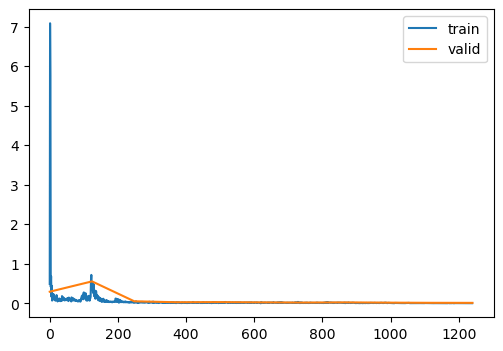

Training took 967.9703934999416 seconds. Results:
 - last train MSE loss: learner.logger.last("train loss") = 0.00390106113627553
 - best train MSE loss: learner.logger.min("train loss") = 0.002111213281750679

 - last test MSE loss: learner.logger.last("test loss") = 0.012666033891340097
 - best test MSE loss: learner.logger.min("test loss") = 0.012666033891340097

 - last train L1 loss: learner.logger.last("train fn - lossf") = 0.04116923362016678
 - best train L1 loss: learner.logger.min("train fn - lossf") = 0.03672260046005249

 - last test L1 loss: learner.logger.last("test fn - lossf") = 0.08756134659051895
 - best test L1 loss: learner.logger.min("test fn - lossf") = 0.08756134659051895


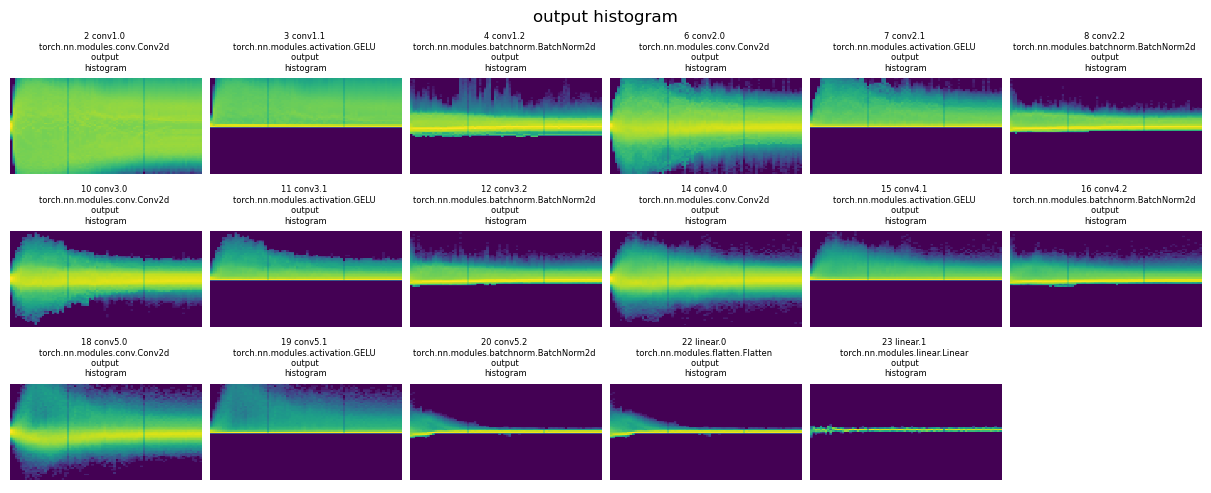

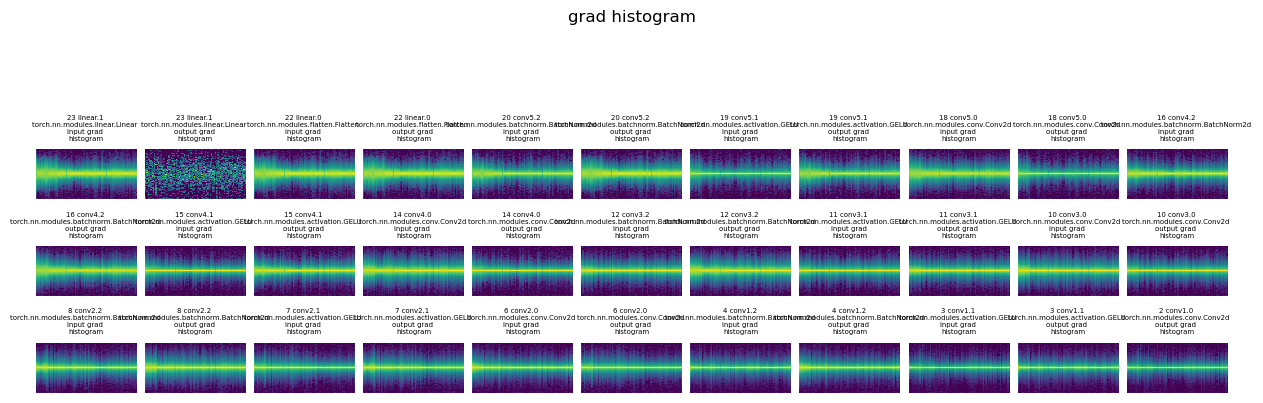

In [10]:
MODEL = CNN_BatchNorm_center()
NAME = MODEL.__class__.__name__
LR = 1e-1
BATCH_SIZE = 16
CACHE_ELEMS = 4
N_EPOCHS = 10

dl_train = CacheRepeatIterator(DataLoader(ds_train, BATCH_SIZE, shuffle=True), CACHE_ELEMS)
dl_test = DataLoader(ds_test, BATCH_SIZE)

LOSS_FN = nn.MSELoss()
OPT = optim.AdamW(MODEL.parameters(), lr=LR)
SCHED = optim.lr_scheduler.OneCycleLR(OPT, max_lr=LR, steps_per_epoch=len(dl_train), epochs=N_EPOCHS)

clean_mem()
# dl_train = DataLoader(ds_train, BATCH_SIZE)
#model = gnn.LSUV(model, dl_train)

CP_FOLDER = "LUMIERE checkpoints"
LEARNER_NAME = f"LUMIERE {NAME} lr={LR} bs={BATCH_SIZE} cache={CACHE_ELEMS} loss = {LOSS_FN.__name__ if hasattr(LOSS_FN, '__name__') else type_str(LOSS_FN)} opt={OPT.__class__.__name__} sch={SCHED.__class__.__name__}"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = (Metric_Loss(), Accelerate("no"), FastProgressBar(plot=True, step_batch=16), Metric_Fn(loss_gen(F.l1_loss)), Log_GradHistorgram(16),
                         Log_SignalHistorgram(16), Log_Time(), Save_Best(CP_FOLDER), Save_Last(CP_FOLDER)),
                  loss_fn=loss_gen(LOSS_FN),
                  optimizer=OPT,
                  scheduler=SCHED)
learner.fit(N_EPOCHS, dl_train, dl_test)

print(f"Training took {learner.logger.last('time')} seconds. Results:")
print(f' - last train MSE loss: {learner.logger.last("train loss") = }')
print(f' - best train MSE loss: {learner.logger.min("train loss") = }')
print()
print(f' - last test MSE loss: {learner.logger.last("test loss") = }')
print(f' - best test MSE loss: {learner.logger.min("test loss") = }')
print()
print(f' - last train L1 loss: {learner.logger.last("train fn - lossf") = }')
print(f' - best train L1 loss: {learner.logger.min("train fn - lossf") = }')
print()
print(f' - last test L1 loss: {learner.logger.last("test fn - lossf") = }')
print(f' - best test L1 loss: {learner.logger.min("test fn - lossf") = }')

plt.show()
learner.logger.hist_all("output histogram")
plt.show()
learner.logger.hist_all("grad histogram")

# Batchnorm lr=1

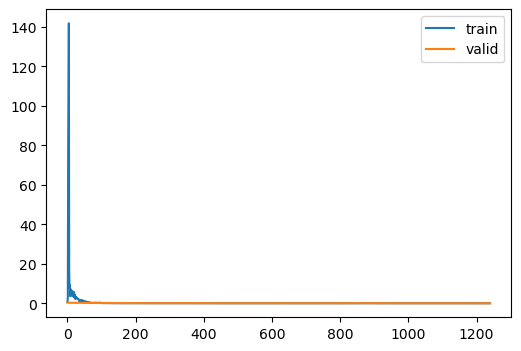

Training took 900.0473476999905 seconds. Results:
 - last train MSE loss: learner.logger.last("train loss") = 0.010416011326014996
 - best train MSE loss: learner.logger.min("train loss") = 0.009854298084974289

 - last test MSE loss: learner.logger.last("test loss") = 0.020787117381890614
 - best test MSE loss: learner.logger.min("test loss") = 0.020787117381890614

 - last train L1 loss: learner.logger.last("train fn - lossf") = 0.08267230540513992
 - best train L1 loss: learner.logger.min("train fn - lossf") = 0.0799744576215744

 - last test L1 loss: learner.logger.last("test fn - lossf") = 0.11390772089362144
 - best test L1 loss: learner.logger.min("test fn - lossf") = 0.11390772089362144


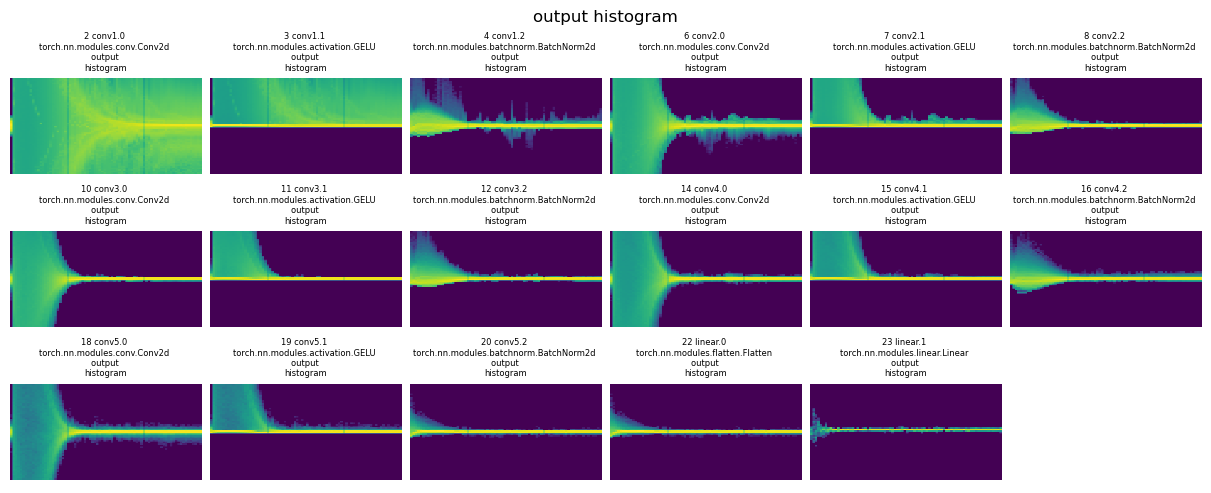

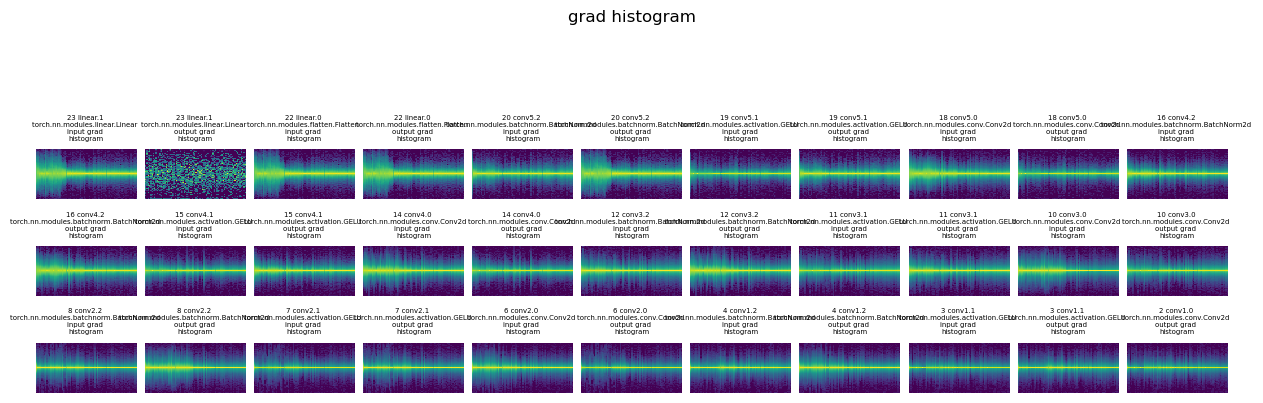

In [11]:
MODEL = CNN_BatchNorm_center()
NAME = MODEL.__class__.__name__
LR = 1
BATCH_SIZE = 16
CACHE_ELEMS = 4
N_EPOCHS = 10

dl_train = CacheRepeatIterator(DataLoader(ds_train, BATCH_SIZE, shuffle=True), CACHE_ELEMS)
dl_test = DataLoader(ds_test, BATCH_SIZE)

LOSS_FN = nn.MSELoss()
OPT = optim.AdamW(MODEL.parameters(), lr=LR)
SCHED = optim.lr_scheduler.OneCycleLR(OPT, max_lr=LR, steps_per_epoch=len(dl_train), epochs=N_EPOCHS)

clean_mem()
# dl_train = DataLoader(ds_train, BATCH_SIZE)
#model = gnn.LSUV(model, dl_train)

CP_FOLDER = "LUMIERE checkpoints"
LEARNER_NAME = f"LUMIERE {NAME} lr={LR} bs={BATCH_SIZE} cache={CACHE_ELEMS} loss = {LOSS_FN.__name__ if hasattr(LOSS_FN, '__name__') else type_str(LOSS_FN)} opt={OPT.__class__.__name__} sch={SCHED.__class__.__name__}"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = (Metric_Loss(), Accelerate("no"), FastProgressBar(plot=True, step_batch=16), Metric_Fn(loss_gen(F.l1_loss)), Log_GradHistorgram(16),
                         Log_SignalHistorgram(16), Log_Time(), Save_Best(CP_FOLDER), Save_Last(CP_FOLDER)),
                  loss_fn=loss_gen(LOSS_FN),
                  optimizer=OPT,
                  scheduler=SCHED)
learner.fit(N_EPOCHS, dl_train, dl_test)

print(f"Training took {learner.logger.last('time')} seconds. Results:")
print(f' - last train MSE loss: {learner.logger.last("train loss") = }')
print(f' - best train MSE loss: {learner.logger.min("train loss") = }')
print()
print(f' - last test MSE loss: {learner.logger.last("test loss") = }')
print(f' - best test MSE loss: {learner.logger.min("test loss") = }')
print()
print(f' - last train L1 loss: {learner.logger.last("train fn - lossf") = }')
print(f' - best train L1 loss: {learner.logger.min("train fn - lossf") = }')
print()
print(f' - last test L1 loss: {learner.logger.last("test fn - lossf") = }')
print(f' - best test L1 loss: {learner.logger.min("test fn - lossf") = }')

plt.show()
learner.logger.hist_all("output histogram")
plt.show()
learner.logger.hist_all("grad histogram")

# Using LSUV instead of batchnorm

In [12]:
class CNN_LSUV_center(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv(16, 24, 4, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.conv2 = conv(24, 32, 3, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.conv3 = conv(32, 48, 2, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.conv4 = conv(48, 64, 2, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.conv5 = conv(64, 64, 2, 2, bias=True, batch_norm=False, dropout=0.0, act=nn.GELU())
        self.linear = linear(64*4*4, 3, flatten=True, act=None)
    def forward(self, x:torch.Tensor):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        return self.linear(x)

summary(CNN_LSUV_center(), (8, 16, 158, 132))

path                                         module                                       input size               output size              params    buffers   
__main__.CNN_LSUV_center/conv1/0             torch.nn.modules.conv.Conv2d                 (8, 16, 158, 132)        (8, 24, 78, 65)          6168      0         
__main__.CNN_LSUV_center/conv1/1             torch.nn.modules.activation.GELU             (8, 24, 78, 65)          (8, 24, 78, 65)          0         0         
__main__.CNN_LSUV_center/conv2/0             torch.nn.modules.conv.Conv2d                 (8, 24, 78, 65)          (8, 32, 38, 32)          6944      0         
__main__.CNN_LSUV_center/conv2/1             torch.nn.modules.activation.GELU             (8, 32, 38, 32)          (8, 32, 38, 32)          0         0         
__main__.CNN_LSUV_center/conv3/0             torch.nn.modules.conv.Conv2d                 (8, 32, 38, 32)          (8, 48, 19, 16)          6192      0         
__main__.CNN_LSUV_center/conv3/1  

[0.008, 0.001, -0.026, 0.003, 0.0], [1.006, 0.992, 1.056, 1.015, 1.0], [11, 11, 11, 11, 11]0]5]
Iteration 3 done.19326867 loss: 0.295805960893631377


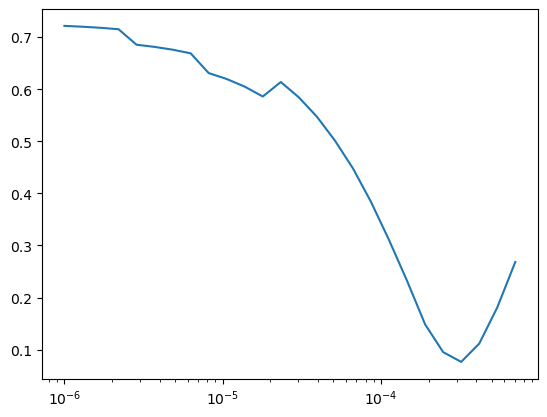

In [13]:
MODEL = CNN_LSUV_center()
BATCH_SIZE = 16
CACHE_ELEMS = 4

LOSS_FN = nn.MSELoss()
OPT = optim.AdamW(MODEL.parameters())

dl_train = CacheRepeatIterator(DataLoader(ds_train, BATCH_SIZE, shuffle=True), CACHE_ELEMS)
MODEL = gnn.LSUV(MODEL, dl_train)
lrs, losses = lr_finder(MODEL, OPT, loss_gen(LOSS_FN), dl_train, mul=1.3, end = 1, niter=4)

[0.004, 0.012, -0.001, 0.004, 0.0], [0.997, 1.005, 1.018, 1.024, 1.0], [11, 11, 11, 11, 11]0]6]]


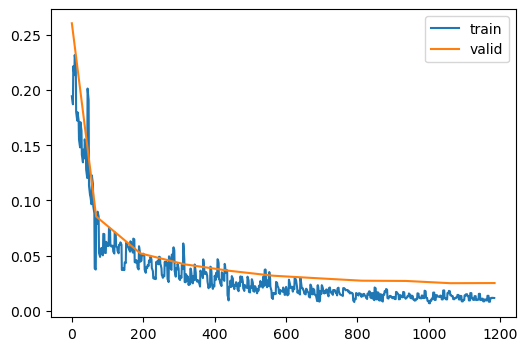

Training took 1188.3327242999803 seconds. Results:
 - last train MSE loss: learner.logger.last("train loss") = 0.011467894539237022
 - best train MSE loss: learner.logger.min("train loss") = 0.006668990012258291

 - last test MSE loss: learner.logger.last("test loss") = 0.025024669244885445
 - best test MSE loss: learner.logger.min("test loss") = 0.02489789854735136

 - last train L1 loss: learner.logger.last("train fn - lossf") = 0.08991420269012451
 - best train L1 loss: learner.logger.min("train fn - lossf") = 0.06581780314445496

 - last test L1 loss: learner.logger.last("test fn - lossf") = 0.1261052985986074
 - best test L1 loss: learner.logger.min("test fn - lossf") = 0.1261052985986074


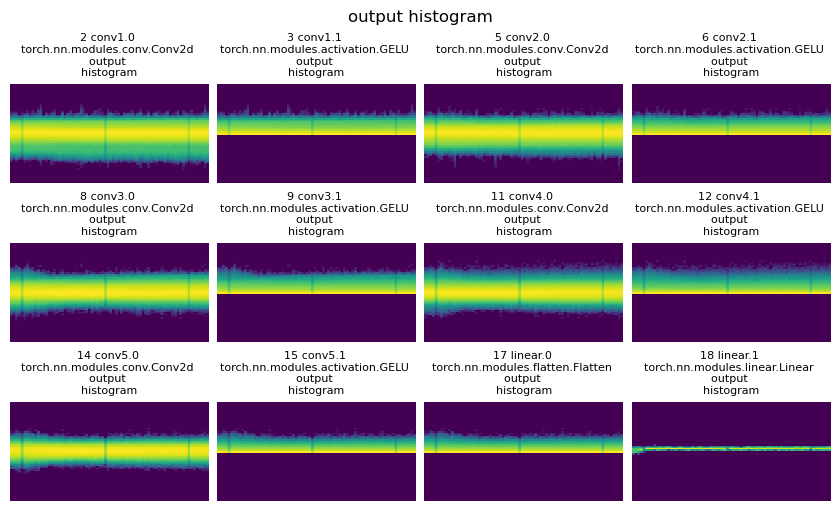

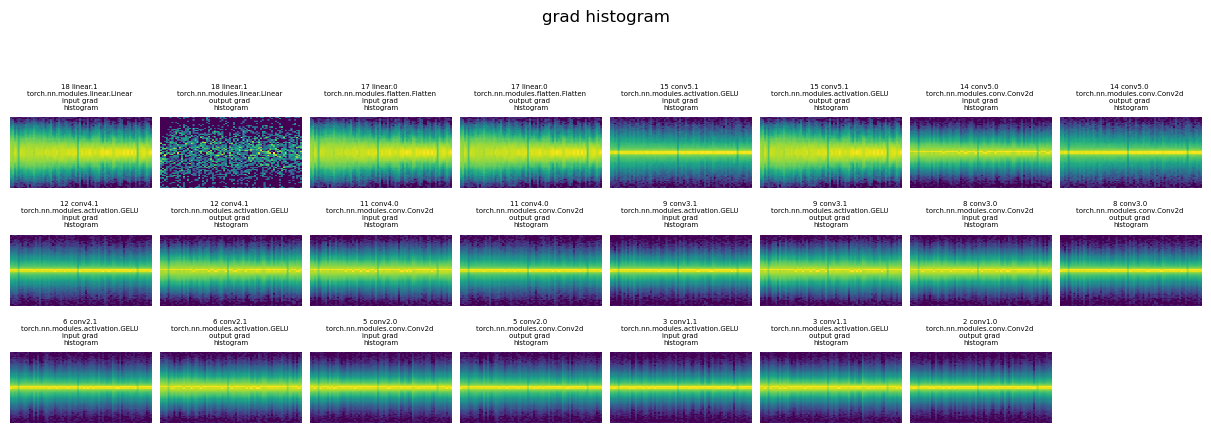

In [14]:
MODEL = CNN_LSUV_center()
NAME = MODEL.__class__.__name__
LR = 1e-4
BATCH_SIZE = 16
CACHE_ELEMS = 4
N_EPOCHS = 10

# dl_train = DataLoader(ds_train, BATCH_SIZE)
dl_train = CacheRepeatIterator(DataLoader(ds_train, BATCH_SIZE, shuffle=True), CACHE_ELEMS)
dl_test = DataLoader(ds_test, BATCH_SIZE)
MODEL = gnn.LSUV(MODEL, dl_train)

LOSS_FN = nn.MSELoss()
OPT = optim.AdamW(MODEL.parameters(), lr=LR)
SCHED = optim.lr_scheduler.OneCycleLR(OPT, max_lr=LR, steps_per_epoch=len(dl_train), epochs=N_EPOCHS)

clean_mem()

CP_FOLDER = "LUMIERE checkpoints"
LEARNER_NAME = f"LUMIERE {NAME} lr={LR} bs={BATCH_SIZE} cache={CACHE_ELEMS} loss = {LOSS_FN.__name__ if hasattr(LOSS_FN, '__name__') else type_str(LOSS_FN)} opt={OPT.__class__.__name__} sch={SCHED.__class__.__name__}"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = (Metric_Loss(), Accelerate("no"), FastProgressBar(plot=True, step_batch=16), Metric_Fn(loss_gen(F.l1_loss)), Log_GradHistorgram(16),
                         Log_SignalHistorgram(16), Log_Time(), Save_Best(CP_FOLDER), Save_Last(CP_FOLDER)),
                  loss_fn=loss_gen(LOSS_FN),
                  optimizer=OPT,
                  scheduler=SCHED)
learner.fit(N_EPOCHS, dl_train, dl_test)

print(f"Training took {learner.logger.last('time')} seconds. Results:")
print(f' - last train MSE loss: {learner.logger.last("train loss") = }')
print(f' - best train MSE loss: {learner.logger.min("train loss") = }')
print()
print(f' - last test MSE loss: {learner.logger.last("test loss") = }')
print(f' - best test MSE loss: {learner.logger.min("test loss") = }')
print()
print(f' - last train L1 loss: {learner.logger.last("train fn - lossf") = }')
print(f' - best train L1 loss: {learner.logger.min("train fn - lossf") = }')
print()
print(f' - last test L1 loss: {learner.logger.last("test fn - lossf") = }')
print(f' - best test L1 loss: {learner.logger.min("test fn - lossf") = }')

plt.show()
learner.logger.hist_all("output histogram")
plt.show()
learner.logger.hist_all("grad histogram")

# LSUV with 1e-03

[-0.003, 0.0, -0.0, -0.001, 0.0], [0.998, 0.988, 1.001, 0.996, 1.0], [11, 11, 11, 11, 11]]9]


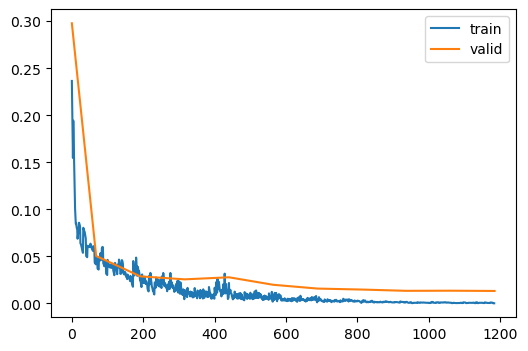

Training took 1154.6265280999942 seconds. Results:
 - last train MSE loss: learner.logger.last("train loss") = 0.00023534990032203496
 - best train MSE loss: learner.logger.min("train loss") = 0.00023534990032203496

 - last test MSE loss: learner.logger.last("test loss") = 0.01333041830609242
 - best test MSE loss: learner.logger.min("test loss") = 0.01333041830609242

 - last train L1 loss: learner.logger.last("train fn - lossf") = 0.011251871474087238
 - best train L1 loss: learner.logger.min("train fn - lossf") = 0.011251871474087238

 - last test L1 loss: learner.logger.last("test fn - lossf") = 0.08928913561006387
 - best test L1 loss: learner.logger.min("test fn - lossf") = 0.08928913561006387


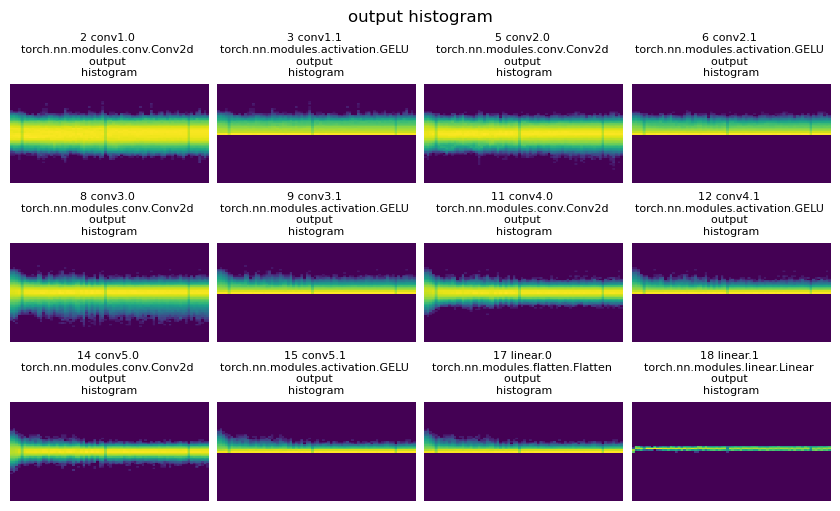

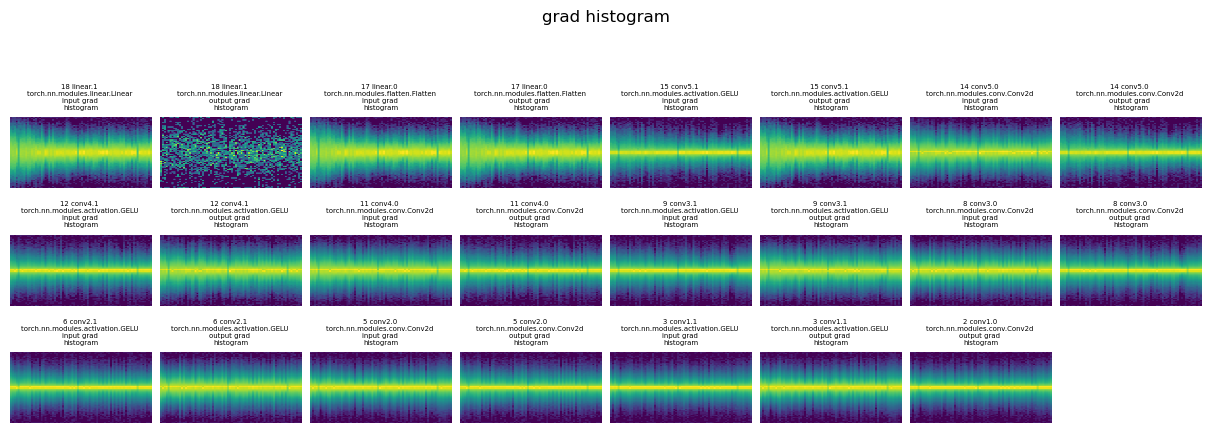

In [15]:
MODEL = CNN_LSUV_center()
NAME = MODEL.__class__.__name__
LR = 1e-3
BATCH_SIZE = 16
CACHE_ELEMS = 4
N_EPOCHS = 10

# dl_train = DataLoader(ds_train, BATCH_SIZE)
dl_train = CacheRepeatIterator(DataLoader(ds_train, BATCH_SIZE, shuffle=True), CACHE_ELEMS)
dl_test = DataLoader(ds_test, BATCH_SIZE)
MODEL = gnn.LSUV(MODEL, dl_train)

LOSS_FN = nn.MSELoss()
OPT = optim.AdamW(MODEL.parameters(), lr=LR)
SCHED = optim.lr_scheduler.OneCycleLR(OPT, max_lr=LR, steps_per_epoch=len(dl_train), epochs=N_EPOCHS)

clean_mem()

CP_FOLDER = "LUMIERE checkpoints"
LEARNER_NAME = f"LUMIERE {NAME} lr={LR} bs={BATCH_SIZE} cache={CACHE_ELEMS} loss = {LOSS_FN.__name__ if hasattr(LOSS_FN, '__name__') else type_str(LOSS_FN)} opt={OPT.__class__.__name__} sch={SCHED.__class__.__name__}"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = (Metric_Loss(), Accelerate("no"), FastProgressBar(plot=True, step_batch=16), Metric_Fn(loss_gen(F.l1_loss)), Log_GradHistorgram(16),
                         Log_SignalHistorgram(16), Log_Time(), Save_Best(CP_FOLDER), Save_Last(CP_FOLDER)),
                  loss_fn=loss_gen(LOSS_FN),
                  optimizer=OPT,
                  scheduler=SCHED)
learner.fit(N_EPOCHS, dl_train, dl_test)

print(f"Training took {learner.logger.last('time')} seconds. Results:")
print(f' - last train MSE loss: {learner.logger.last("train loss") = }')
print(f' - best train MSE loss: {learner.logger.min("train loss") = }')
print()
print(f' - last test MSE loss: {learner.logger.last("test loss") = }')
print(f' - best test MSE loss: {learner.logger.min("test loss") = }')
print()
print(f' - last train L1 loss: {learner.logger.last("train fn - lossf") = }')
print(f' - best train L1 loss: {learner.logger.min("train fn - lossf") = }')
print()
print(f' - last test L1 loss: {learner.logger.last("test fn - lossf") = }')
print(f' - best test L1 loss: {learner.logger.min("test fn - lossf") = }')

plt.show()
learner.logger.hist_all("output histogram")
plt.show()
learner.logger.hist_all("grad histogram")

# LSUV 1e-02

[-0.008, 0.004, 0.019, 0.002, 0.0], [0.991, 0.968, 0.977, 0.992, 1.0], [11, 11, 11, 11, 11]0]9]


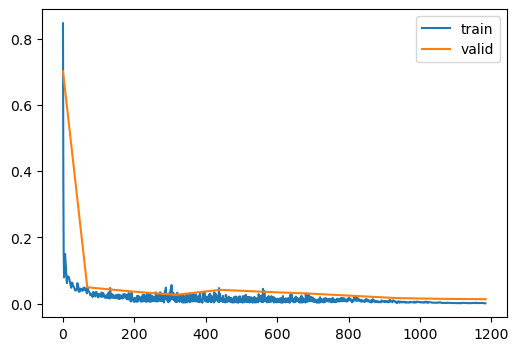

Training took 1031.7193850000622 seconds. Results:
 - last train MSE loss: learner.logger.last("train loss") = 0.0008221626630984247
 - best train MSE loss: learner.logger.min("train loss") = 0.0008221626630984247

 - last test MSE loss: learner.logger.last("test loss") = 0.013124735405047735
 - best test MSE loss: learner.logger.min("test loss") = 0.013124735405047735

 - last train L1 loss: learner.logger.last("train fn - lossf") = 0.022617217153310776
 - best train L1 loss: learner.logger.min("train fn - lossf") = 0.021945051848888397

 - last test L1 loss: learner.logger.last("test fn - lossf") = 0.08638025571902593
 - best test L1 loss: learner.logger.min("test fn - lossf") = 0.08638025571902593


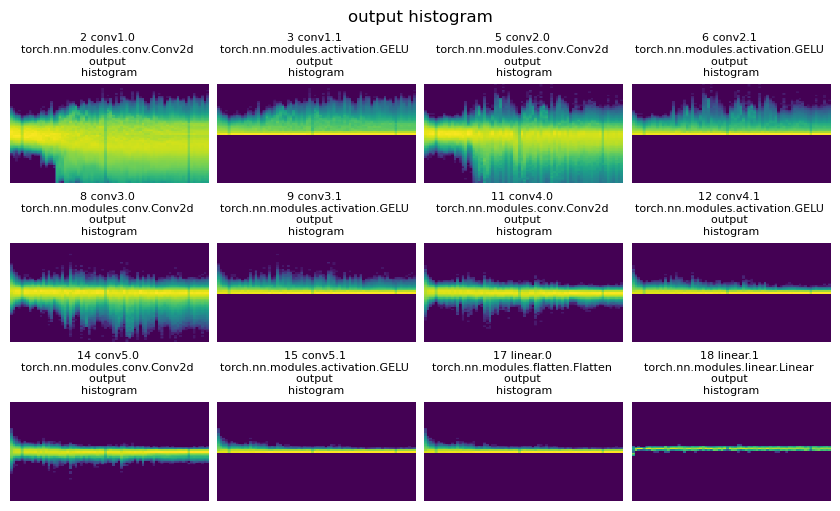

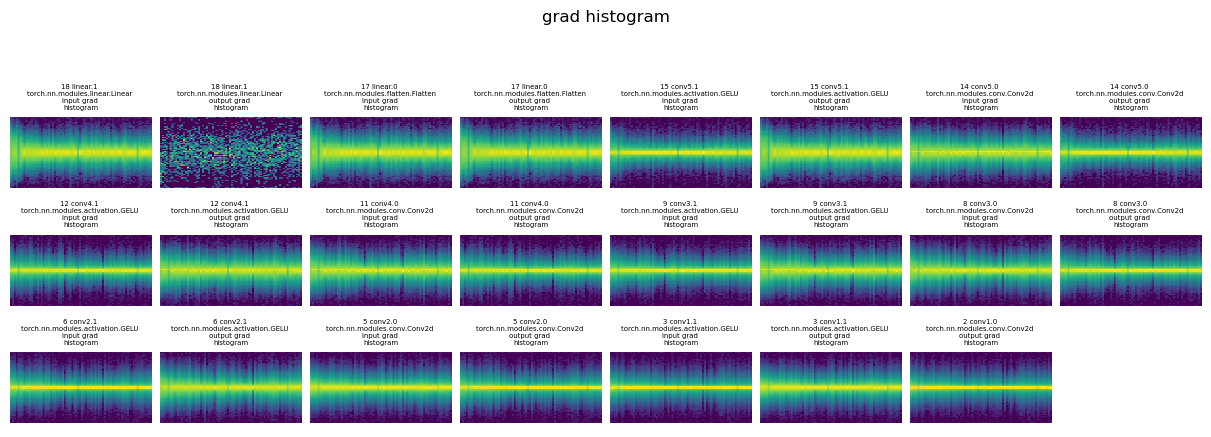

In [16]:
MODEL = CNN_LSUV_center()
NAME = MODEL.__class__.__name__
LR = 1e-2
BATCH_SIZE = 16
CACHE_ELEMS = 4
N_EPOCHS = 10

# dl_train = DataLoader(ds_train, BATCH_SIZE)
dl_train = CacheRepeatIterator(DataLoader(ds_train, BATCH_SIZE, shuffle=True), CACHE_ELEMS)
dl_test = DataLoader(ds_test, BATCH_SIZE)
MODEL = gnn.LSUV(MODEL, dl_train)

LOSS_FN = nn.MSELoss()
OPT = optim.AdamW(MODEL.parameters(), lr=LR)
SCHED = optim.lr_scheduler.OneCycleLR(OPT, max_lr=LR, steps_per_epoch=len(dl_train), epochs=N_EPOCHS)

clean_mem()

CP_FOLDER = "LUMIERE checkpoints"
LEARNER_NAME = f"LUMIERE {NAME} lr={LR} bs={BATCH_SIZE} cache={CACHE_ELEMS} loss = {LOSS_FN.__name__ if hasattr(LOSS_FN, '__name__') else type_str(LOSS_FN)} opt={OPT.__class__.__name__} sch={SCHED.__class__.__name__}"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = (Metric_Loss(), Accelerate("no"), FastProgressBar(plot=True, step_batch=16), Metric_Fn(loss_gen(F.l1_loss)), Log_GradHistorgram(16),
                         Log_SignalHistorgram(16), Log_Time(), Save_Best(CP_FOLDER), Save_Last(CP_FOLDER)),
                  loss_fn=loss_gen(LOSS_FN),
                  optimizer=OPT,
                  scheduler=SCHED)
learner.fit(N_EPOCHS, dl_train, dl_test)

print(f"Training took {learner.logger.last('time')} seconds. Results:")
print(f' - last train MSE loss: {learner.logger.last("train loss") = }')
print(f' - best train MSE loss: {learner.logger.min("train loss") = }')
print()
print(f' - last test MSE loss: {learner.logger.last("test loss") = }')
print(f' - best test MSE loss: {learner.logger.min("test loss") = }')
print()
print(f' - last train L1 loss: {learner.logger.last("train fn - lossf") = }')
print(f' - best train L1 loss: {learner.logger.min("train fn - lossf") = }')
print()
print(f' - last test L1 loss: {learner.logger.last("test fn - lossf") = }')
print(f' - best test L1 loss: {learner.logger.min("test fn - lossf") = }')

plt.show()
learner.logger.hist_all("output histogram")
plt.show()
learner.logger.hist_all("grad histogram")